In [32]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os

## Load the dataset

In [3]:
from DatasetHandler import DatasetHandler

### 1. Initialize the dataset handler

In [4]:
datasetHandler = DatasetHandler('EuroSAT')
datasetHandler.print_classes()

Classes: 
     Class 0 -> EuroSAT/Forest
     Class 1 -> EuroSAT/River
     Class 2 -> EuroSAT/Highway
     Class 3 -> EuroSAT/AnnualCrop
     Class 4 -> EuroSAT/SeaLake
     Class 5 -> EuroSAT/HerbaceousVegetation
     Class 6 -> EuroSAT/Industrial
     Class 7 -> EuroSAT/Residential
     Class 8 -> EuroSAT/PermanentCrop
     Class 9 -> EuroSAT/Pasture


### 2. Select the two classes for the binary classification

In [5]:
class_1 = 0 #int(input('Class 1 [0-9]: '))
class_2 = 1 #int(input('Class 2 [0-9]: '))
print(datasetHandler.classes[class_1])
print(datasetHandler.classes[class_2])

classes_name = []
classes_name.append(datasetHandler.classes[class_1].split('/')[-1])
classes_name.append(datasetHandler.classes[class_2].split('/')[-1])

EuroSAT/Forest
EuroSAT/River


### 3. Load paths and labels

In [6]:
imgs_path, imgs_label = datasetHandler.load_paths_labels(classes = [datasetHandler.classes[class_1], datasetHandler.classes[class_2]])

print('Dataset images: ', len(imgs_path))
print('Dataset labels: ', len(imgs_label))
print('Dataset sample -> image path: ', imgs_path[0], ' image label', imgs_label[0])

Dataset images:  5500
Dataset labels:  5500
Dataset sample -> image path:  EuroSAT/River/River_807.jpg  image label [0. 1.]


### 4. Trainining-Validation split

In [7]:
train_images, train_labels, val_images, val_labels = datasetHandler.train_validation_split(imgs_path, imgs_label, split_factor = 0.2)
print('Training images: ',  train_images.shape)
print('Training labels: ',  train_labels.shape)
print('Validatiom images: ',  val_images.shape)
print('Validation labels: ',  val_labels.shape)

Training images:  (4400,)
Training labels:  (4400, 2)
Validatiom images:  (1100,)
Validation labels:  (1100, 2)


### 5. Display a sample of the dataset

In [8]:
from utils import plotDataset

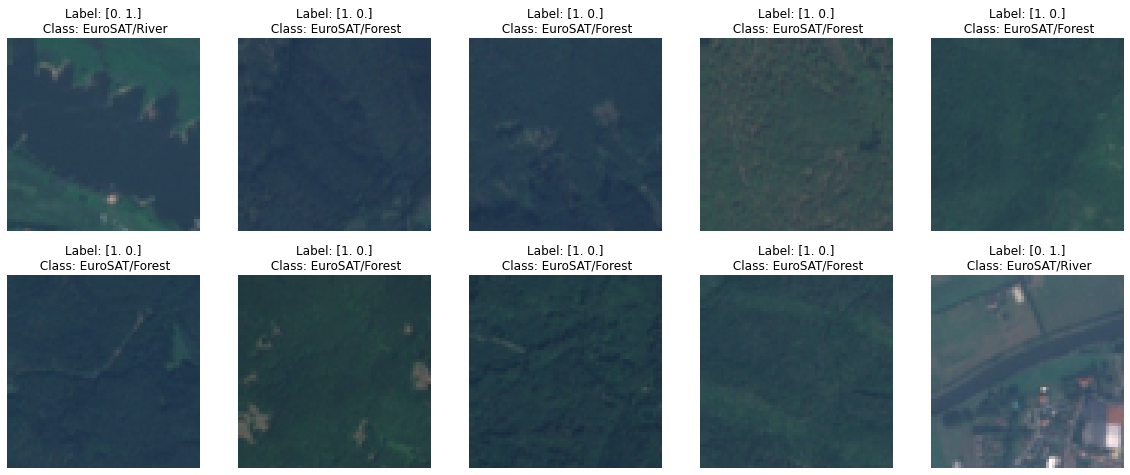

In [9]:
plotDataset(train_images, train_labels, datasetHandler.classes, 5, 2)

## CNN classifier

In [14]:
from CNN_Classifier import CNN_Classifier

### 1. Initialize the CNN model

In [15]:
img_shape = plt.imread(train_images[0]).shape
n_classes = train_labels.shape[1]

cnn = CNN_Classifier(img_shape = img_shape, n_classes = n_classes)

In [16]:
cnn.model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 3)         228       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 6)         456       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 400)               0

### 2. Train the CNN model

In [17]:
batch_size = 16
epochs = 20
train_generator = datasetHandler.cnn_data_loader(train_images, train_labels, batch_size = batch_size, img_shape = img_shape, n_classes = n_classes)
val_generator = datasetHandler.cnn_data_loader(val_images, val_labels, batch_size = batch_size, img_shape = img_shape, n_classes = n_classes)

history = cnn.train_model(epochs, batch_size, train_generator, val_generator, len(train_images), len(val_images))

Epoch 1/20
275/275 [==============================] - 8s 28ms/step - loss: 0.6611 - accuracy: 0.6398 - val_loss: 0.3883 - val_accuracy: 0.8676
Epoch 2/20
275/275 [==============================] - 7s 26ms/step - loss: 0.3426 - accuracy: 0.8709 - val_loss: 0.2992 - val_accuracy: 0.8805
Epoch 3/20
275/275 [==============================] - 7s 25ms/step - loss: 0.2885 - accuracy: 0.8950 - val_loss: 0.2492 - val_accuracy: 0.8961
Epoch 4/20
275/275 [==============================] - 7s 25ms/step - loss: 0.2236 - accuracy: 0.9163 - val_loss: 0.2367 - val_accuracy: 0.9072
Epoch 5/20
275/275 [==============================] - 6s 23ms/step - loss: 0.2097 - accuracy: 0.9254 - val_loss: 0.2084 - val_accuracy: 0.9265
Epoch 6/20
275/275 [==============================] - 6s 23ms/step - loss: 0.2207 - accuracy: 0.9226 - val_loss: 0.2019 - val_accuracy: 0.9393
Epoch 7/20
275/275 [==============================] - 7s 24ms/step - loss: 0.1920 - accuracy: 0.9354 - val_loss: 0.2022 - val_accuracy: 0.9228

#### After training the CNN model, save it in the trained_models folder

In [18]:
#cnn.model.save(os.path.join('trained_models', 'CNN-' + classes_name[0] + '-VS-' + classes_name[1] + '.h5'))

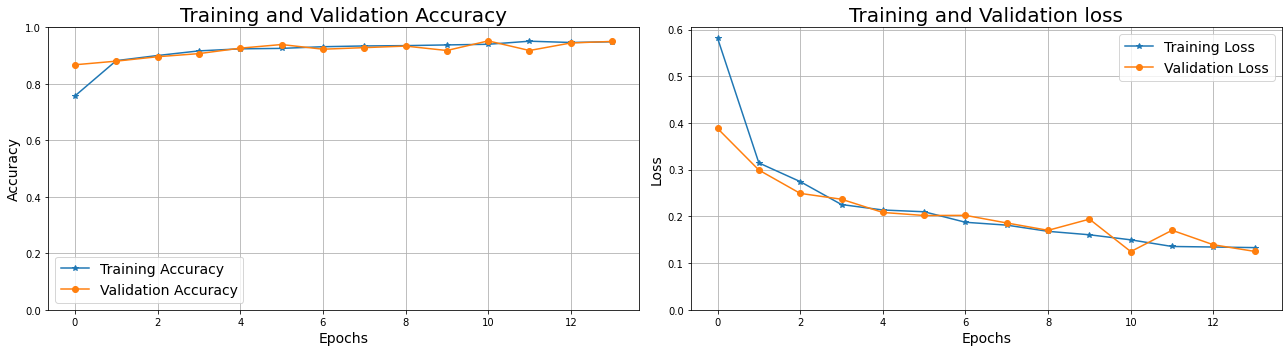

In [19]:
from utils import plotCNNhistory
plotCNNhistory(history)

### 3. Test the CNN model

In [20]:
from tensorflow.keras.models import load_model
cnn.model = load_model(os.path.join('trained_models', 'CNN-' + classes_name[0] + '-VS-' + classes_name[1] + '.h5'))

In [21]:
val_data_generator = datasetHandler.cnn_data_loader(val_images, val_labels, batch_size = len(val_images), img_shape = img_shape, n_classes = n_classes)
accuracy, precision, recall, f1 = cnn.evaluate_model(val_data_generator, classes_name)

Accuracy: 97.27 %
Precion: 98.89 %
Recall: 98.35 %
F1 score: 98.62 %


## QCNN Classifier

In [30]:
from QNN4EO import QNN4EO

### 1. Initialize the model

In [32]:
qnn4eo = QNN4EO()

In [33]:
img_shape = plt.imread(train_images[0]).shape
n_classes = train_labels.shape[1]
epochs = 20

train_generator = datasetHandler.qcnn_data_loader(train_images, train_labels, batch_size = 1, img_shape = img_shape)
loss_list = qnn4eo.train_model(epochs, train_generator, len(train_images))

 Image 138 of 4400 Loss: -0.52000

KeyboardInterrupt: 

In [25]:
val_data_gen = datasetHandler.qcnn_data_loader(val_images, val_labels, batch_size = 1, img_shape = img_shape)
accuracy, precision, recall, f1 = qnn4eo.evaluate_model(val_data_gen, len(val_images))

Accuracy: 97.18 %
Precion: 98.16 %
Recall: 98.98 %
F1 score: 98.57 %


# Running all the binary classification tests

In [23]:
from matplotlib.colors import LinearSegmentedColormap
from CNN_Classifier import CNN_Classifier
from DatasetHandler import DatasetHandler
from QNN4EO import QNN4EO
import seaborn as sns

In [24]:
datasetHandler = DatasetHandler('EuroSAT')

In [29]:
epochs = 20
batch_size = 1

cnn_results = np.zeros((10, 10, 4))
qnn4eo_results = np.zeros((10, 10, 4))
classes_name = []

for i in range(10):
    class_1 = i
    classes_name.append(datasetHandler.classes[class_1].split('/')[-1])
    for j in range(10):
        if i!=j and j>i:
            class_2 = j

            print("\033[1m" + 'Load dataset:' + "\033[0m")
            print(datasetHandler.classes[class_1])
            print(datasetHandler.classes[class_2])

            cs = []
            cs.append(datasetHandler.classes[class_1].split('/')[-1])
            cs.append(datasetHandler.classes[class_2].split('/')[-1])

            imgs_path, imgs_label = datasetHandler.load_paths_labels(classes = [datasetHandler.classes[class_1], datasetHandler.classes[class_2]])
            train_images, train_labels, val_images, val_labels = datasetHandler.train_validation_split(imgs_path, imgs_label, split_factor = 0.2)

            img_shape = plt.imread(train_images[0]).shape
            n_classes = train_labels.shape[1]

            print("\033[1m" + 'Train CNN:' + "\033[0m")
            cnn = CNN_Classifier(img_shape = img_shape, n_classes = n_classes)
            train_generator = datasetHandler.cnn_data_loader(train_images, train_labels, batch_size = batch_size, img_shape = img_shape, n_classes = n_classes)
            val_generator = datasetHandler.cnn_data_loader(val_images, val_labels, batch_size = batch_size, img_shape = img_shape, n_classes = n_classes)
            history = cnn.train_model(epochs, batch_size, train_generator, val_generator, len(train_images), len(val_images))

            print("\033[1m" + 'Test CNN:' + "\033[0m")
            val_data_generator = datasetHandler.cnn_data_loader(val_images, val_labels, batch_size = len(val_images), img_shape = img_shape, n_classes = n_classes)
            cnn_results[i,j,...] = cnn.evaluate_model(val_data_generator, cs)

            print("\033[1m" + 'Train QNN4EO:' + "\033[0m")
            qnn4eo = QNN4EO()
            img_shape = plt.imread(train_images[0]).shape
            train_generator = datasetHandler.qcnn_data_loader(train_images, train_labels, batch_size = batch_size, img_shape = img_shape)
            loss_list = qnn4eo.train_model(epochs, train_generator, len(train_images))

            print("\033[1m" + 'Test QNN4EO:' + "\033[0m")
            val_data_gen = datasetHandler.qcnn_data_loader(val_images, val_labels, batch_size = batch_size, img_shape = img_shape)
            qnn4eo_results[i,j,...] = qnn4eo.evaluate_model(val_data_gen, len(val_images))

        elif i==j:
            cnn_results[i,j] = np.nan
            qnn4eo_results[i,j] = np.nan


Load dataset:
EuroSAT/Forest
EuroSAT/River
Train CNN:
4400/4400 [==============================] - 16s 4ms/step - loss: 0.6819 - accuracy: 0.4691 - val_loss: 0.6396 - val_accuracy: 0.4364
Training time:  16.224591732025146
Test CNN:
Accuracy: 42.55 %
Precion: 100.00 %
Recall: 42.55 %
F1 score: 59.69 %
Train QNN4EO:
 Image 1471 of 4400 Loss: -0.78000

KeyboardInterrupt: 

## Confusion matricies

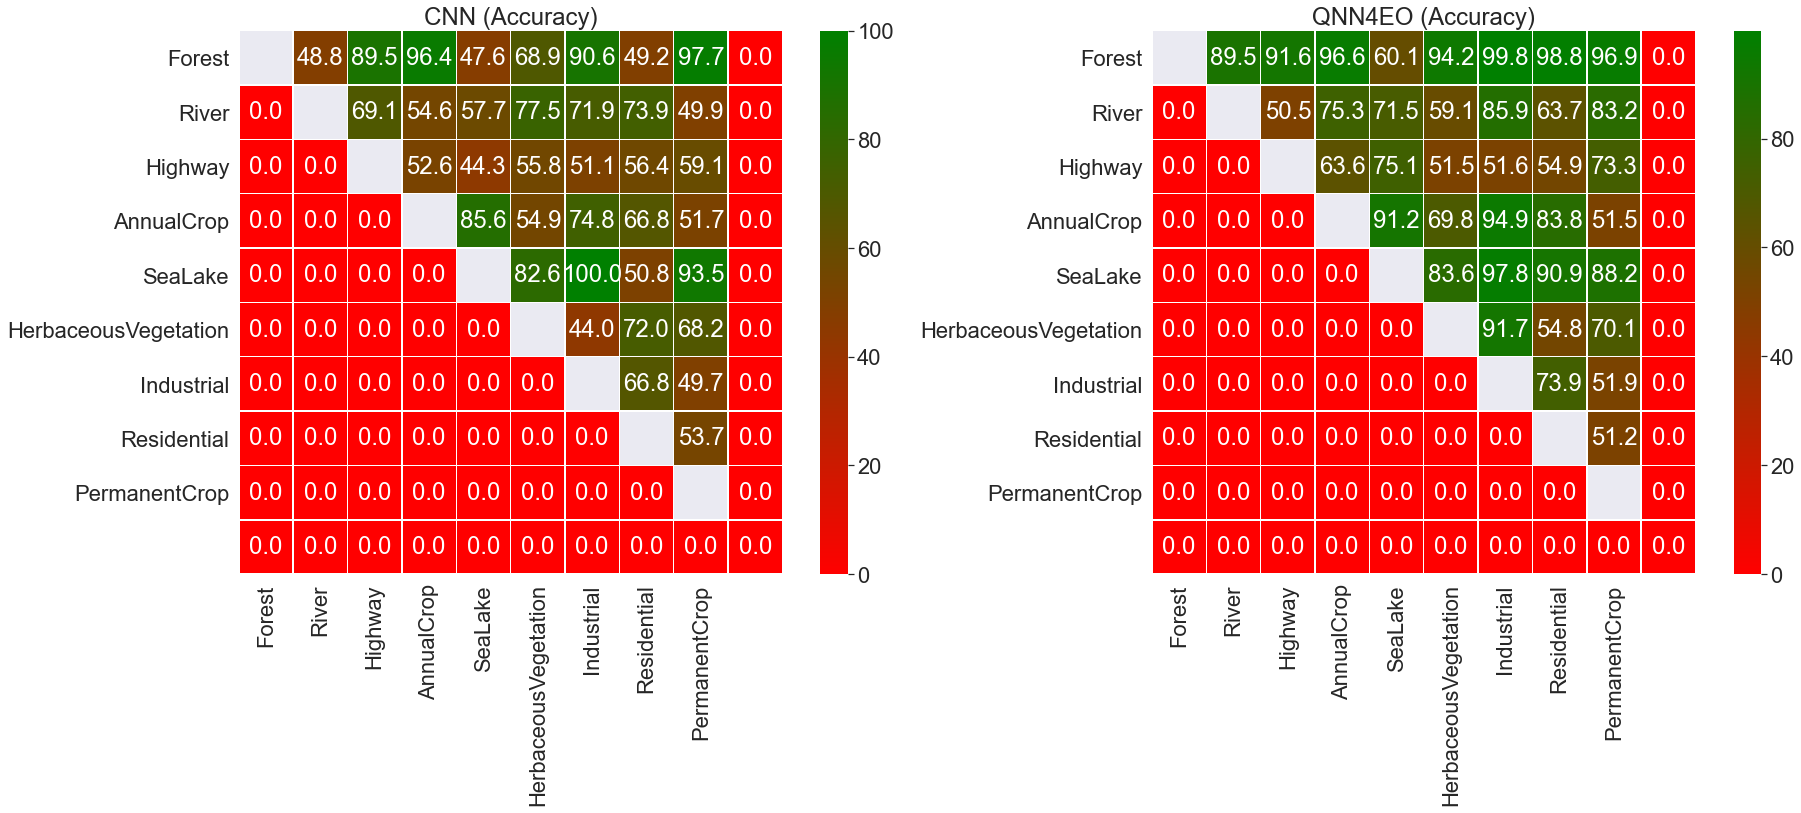

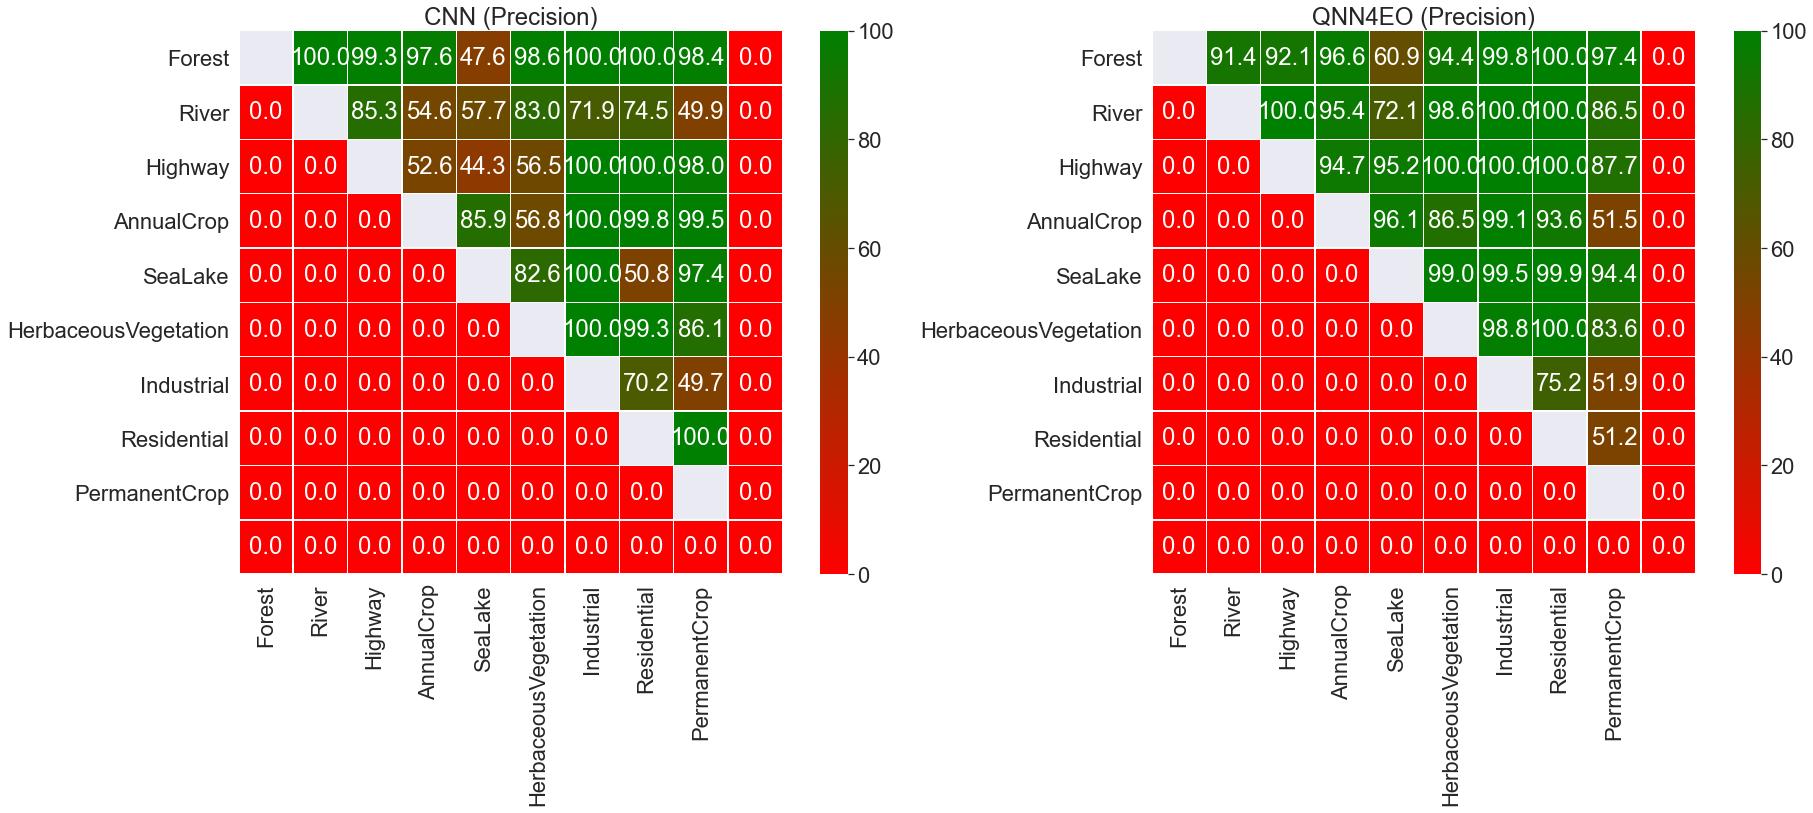

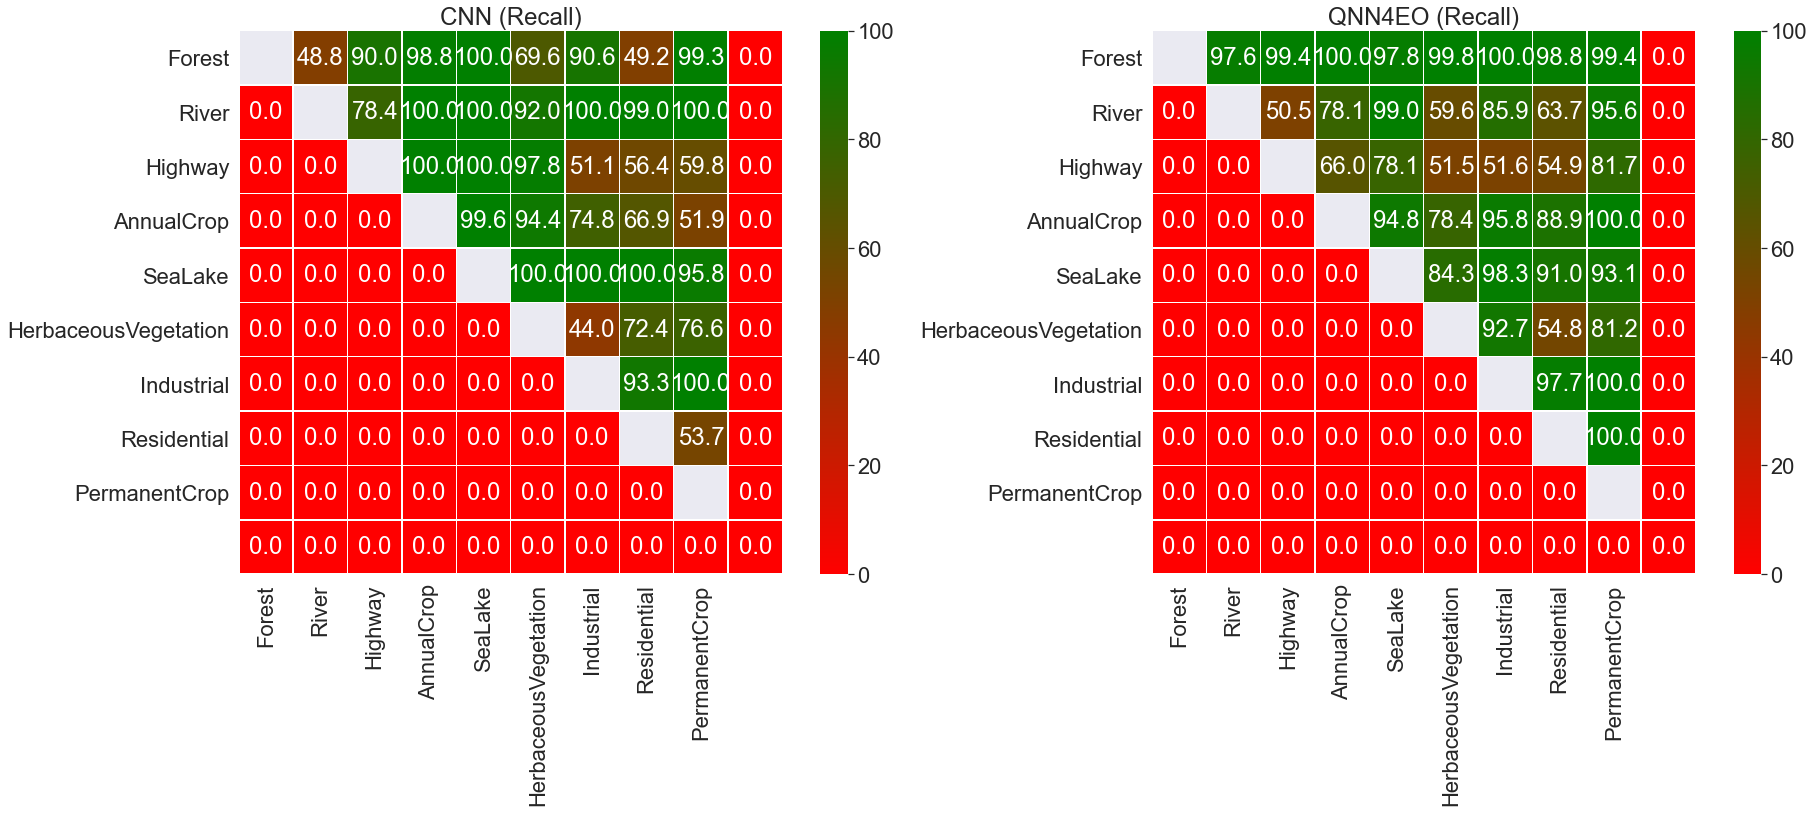

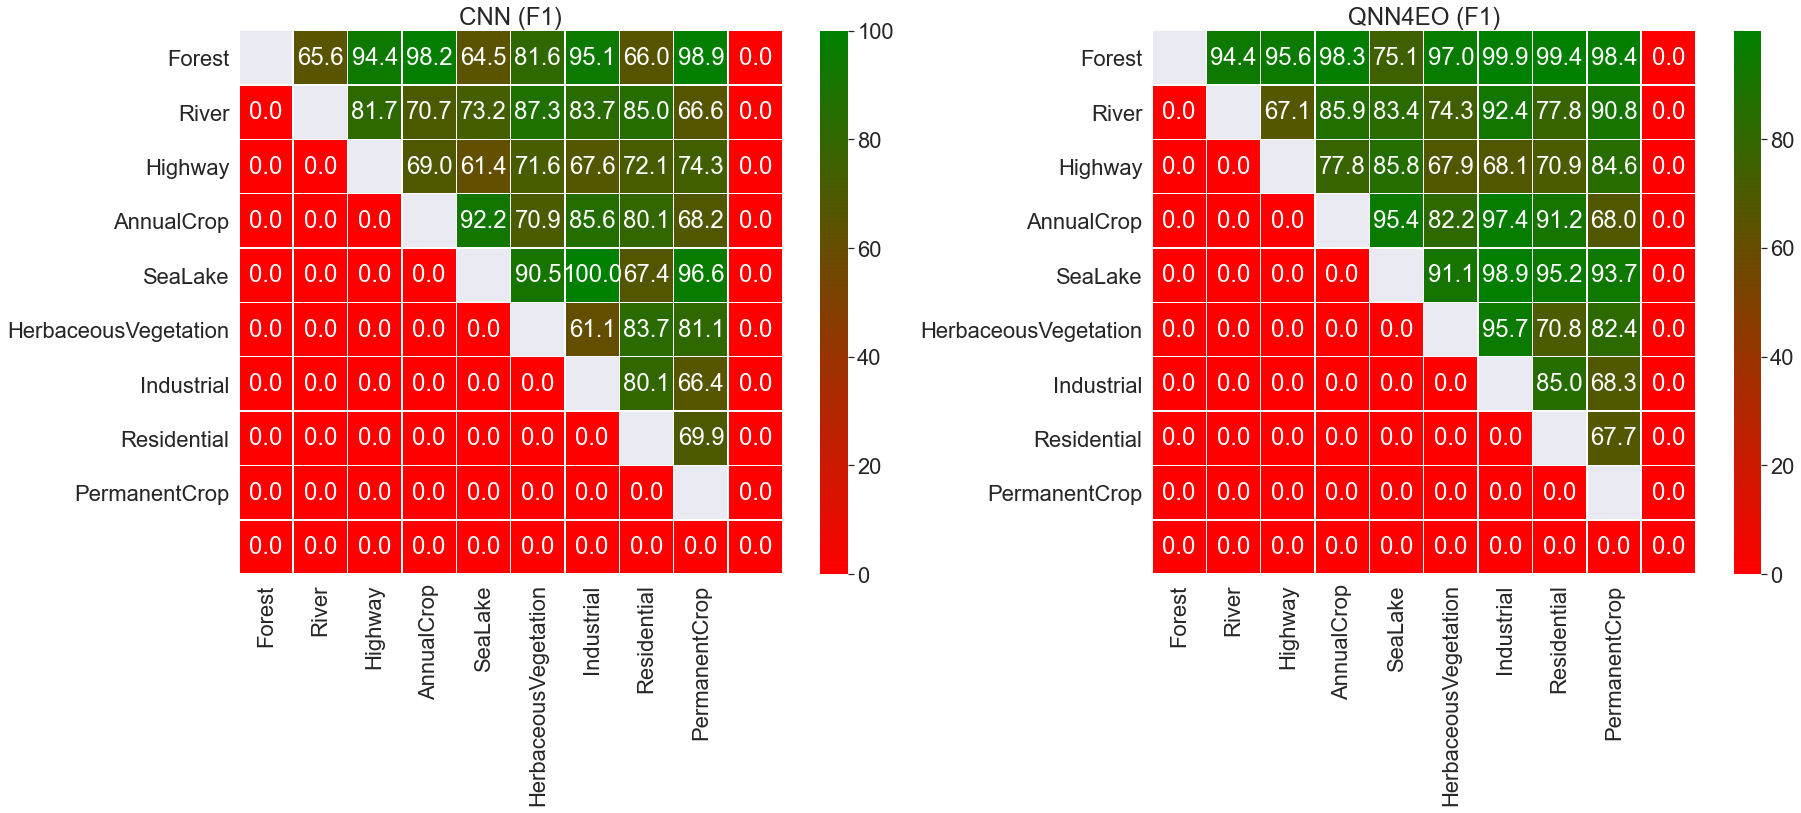

In [28]:
cmap = LinearSegmentedColormap.from_list(
    name='red-green', 
    colors=['red','green']
)

sns.set(font_scale=2)

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (30, 10))

sns.heatmap(cnn_results[...,0], linewidth=0.5, fmt='.1f', square = True, cmap = cmap, 
            annot = True, xticklabels = classes_name, yticklabels = classes_name, ax = axes[0]).set(title='CNN (Accuracy)')
sns.heatmap(qnn4eo_results[...,0], linewidth=0.5, fmt='.1f', square = True, cmap = cmap, 
            annot = True, xticklabels = classes_name, yticklabels = classes_name, ax = axes[1]).set(title='QNN4EO (Accuracy)')
plt.show()

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (30, 10))
sns.heatmap(cnn_results[...,1], linewidth=0.5, fmt='.1f', square = True, cmap = cmap, 
            annot = True, xticklabels = classes_name, yticklabels = classes_name, ax = axes[0]).set(title='CNN (Precision)')
sns.heatmap(qnn4eo_results[...,1], linewidth=0.5, fmt='.1f', square = True, cmap = cmap, 
            annot = True, xticklabels = classes_name, yticklabels = classes_name, ax = axes[1]).set(title='QNN4EO (Precision)')
plt.show()

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (30, 10))
sns.heatmap(cnn_results[...,2], linewidth=0.5, fmt='.1f', square = True, cmap = cmap, 
            annot = True, xticklabels = classes_name, yticklabels = classes_name, ax = axes[0]).set(title='CNN (Recall)')
sns.heatmap(qnn4eo_results[...,2], linewidth=0.5, fmt='.1f',  square = True, cmap = cmap, 
            annot = True, xticklabels = classes_name, yticklabels = classes_name, ax = axes[1]).set(title='QNN4EO (Recall)')
plt.show()

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (30, 10))
sns.heatmap(cnn_results[...,3], linewidth=0.5, fmt='.1f', square = True, cmap = cmap, 
            annot = True, xticklabels = classes_name, yticklabels = classes_name, ax = axes[0]).set(title='CNN (F1)')
sns.heatmap(qnn4eo_results[...,3], linewidth=0.5, fmt='.1f', square = True, cmap = cmap, 
            annot = True, xticklabels = classes_name, yticklabels = classes_name, ax = axes[1]).set(title='QNN4EO (F1)')
plt.show()

# Paper Results

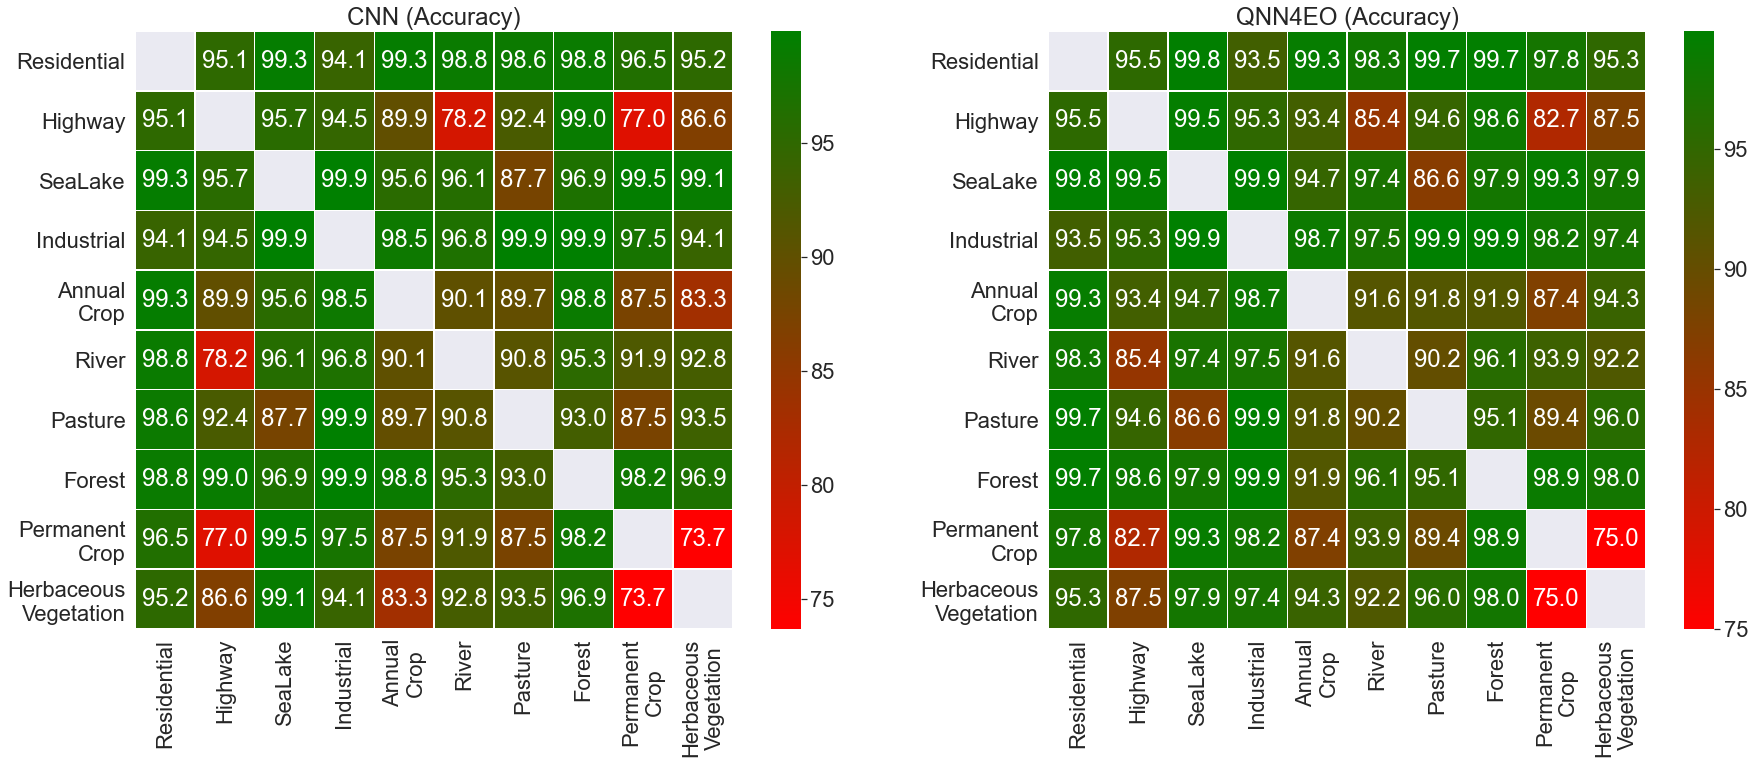

In [37]:
from paper_results import import_results
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from CNN_Classifier import CNN_Classifier
from QNN4EO import QNN4EO


cnn_results, qnn4eo_results, classes_name = import_results()

cmap = LinearSegmentedColormap.from_list(
    name='red-green', 
    colors=['red','green']
)

sns.set(font_scale=2)

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (30, 11))
sns.heatmap(cnn_results, linewidth=0.5, fmt='.1f', square = True, cmap = cmap, 
            annot = True, xticklabels = classes_name, yticklabels = classes_name, ax = axes[0]).set(title='CNN (Accuracy)')
sns.heatmap(qnn4eo_results, linewidth=0.5, fmt='.1f', square = True, cmap = cmap, 
            annot = True, xticklabels = classes_name, yticklabels = classes_name, ax = axes[1]).set(title='QNN4EO (Accuracy)')
plt.show()